In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore") 

In [2]:
import os
import sys
import math
import pandas as pd
import sklearn.preprocessing
from tempfile import TemporaryDirectory
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

from recommenders.utils.constants import (
    DEFAULT_USER_COL as USER_COL,
    DEFAULT_ITEM_COL as ITEM_COL,
    DEFAULT_RATING_COL as RATING_COL,
    DEFAULT_PREDICTION_COL as PREDICT_COL,
    DEFAULT_GENRE_COL as ITEM_FEAT_COL,
    SEED
)
from recommenders.utils import tf_utils, gpu_utils, plot
from recommenders.datasets import movielens
from recommenders.datasets.pandas_df_utils import user_item_pairs
from recommenders.datasets.python_splitters import python_random_split
import recommenders.evaluation.python_evaluation as evaluator
import recommenders.models.wide_deep.wide_deep_utils as wide_deep
#from recommenders.utils.notebook_utils import store_metadata

print(f"System version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")
print(f"GPUs: {gpu_utils.get_gpu_info()[0]}")

System version: 3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]
Tensorflow version: 2.7.4
GPUs: {'device_name': 'NVIDIA RTX A3000 Laptop GPU', 'total_memory': 6143.5, 'free_memory': 5124.0}


In [3]:
# Parameters 

# Recommend top k items
TOP_K = 3
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = "100"
# Metrics to use for evaluation
RANKING_METRICS = [ evaluator.ndcg_at_k.__name__, evaluator.precision_at_k.__name__ ]
RATING_METRICS = [ evaluator.rmse.__name__, evaluator.mae.__name__ ]
# Use session hook to evaluate model while training
EVALUATE_WHILE_TRAINING = True

RANDOM_SEED = SEED  # Set seed for deterministic result

# Train and test set pickle file paths. If provided, use them. Otherwise, download the MovieLens dataset.
DATA_DIR = None
TRAIN_PICKLE_PATH = None
TEST_PICKLE_PATH = None
EXPORT_DIR_BASE = os.path.join("outputs", "model")
# Model checkpoints directory. If None, use temp-dir.
MODEL_DIR = None

#### Hyperparameters
MODEL_TYPE = "wide_deep"
STEPS = 50000  # Number of batches to train
BATCH_SIZE = 32
# Wide (linear) model hyperparameters
LINEAR_OPTIMIZER = "adagrad"
LINEAR_OPTIMIZER_LR = 0.0621  # Learning rate
LINEAR_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
LINEAR_L2_REG = 0.0
LINEAR_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# DNN model hyperparameters
DNN_OPTIMIZER = "adadelta"
DNN_OPTIMIZER_LR = 0.1
DNN_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
DNN_L2_REG = 0.0
DNN_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# Layer dimensions. Defined as follows to make this notebook runnable from Hyperparameter tuning services like AzureML Hyperdrive
DNN_HIDDEN_LAYER_1 = 0     # Set 0 to not use this layer
DNN_HIDDEN_LAYER_2 = 64    # Set 0 to not use this layer
DNN_HIDDEN_LAYER_3 = 128   # Set 0 to not use this layer
DNN_HIDDEN_LAYER_4 = 512   # Note, at least one layer should have nodes.
DNN_HIDDEN_UNITS = [h for h in [DNN_HIDDEN_LAYER_1, DNN_HIDDEN_LAYER_2, DNN_HIDDEN_LAYER_3, DNN_HIDDEN_LAYER_4] if h > 0]
DNN_USER_DIM = 32          # User embedding feature dimension
DNN_ITEM_DIM = 16          # Item embedding feature dimension
DNN_DROPOUT = 0.8
DNN_BATCH_NORM = 1         # 1 to use batch normalization, 0 if not.

In [4]:
if MODEL_DIR is None:
    TMP_DIR = TemporaryDirectory()
    model_dir = TMP_DIR.name
else:
    if os.path.exists(MODEL_DIR) and os.listdir(MODEL_DIR):
        raise ValueError(
            "Model exists in {}. Use different directory name or "
            "remove the existing checkpoint files first".format(MODEL_DIR)
        )
    TMP_DIR = None
    model_dir = MODEL_DIR

In [5]:
import pandas as pd

use_preset = (TRAIN_PICKLE_PATH is not None and TEST_PICKLE_PATH is not None)
if not use_preset:
    file_path = './dataset.csv'
    data = pd.read_csv(file_path, usecols=['userID', 'itemID', 'rating', 'genre'])
    display(data.head())


,userID,itemID,rating,genre
0,59,4,4.3,'Software Testing'
1,22,7,4.5,'Web Development'
2,38,4,4.6,'Game Art & Graphics'
3,89,18,2.1,'Management'
4,11,5,1.2,'CAD & 3D Modeling'


In [6]:
if not use_preset and ITEM_FEAT_COL is not None:
    # Encode 'genres' into int array (multi-hot representation) to use as item features
    genres_encoder = sklearn.preprocessing.MultiLabelBinarizer()
    data[ITEM_FEAT_COL] = genres_encoder.fit_transform(
        data[ITEM_FEAT_COL].apply(lambda s: s.split("|"))
    ).tolist()
    print("genre:", genres_encoder.classes_)
    display(data.head())

genre: ["'AI & ChatGPT Applications'" "'Algorithms & Data Structures'"
 "'Backend'" "'Blockchain'" "'CAD & 3D Modeling'" "'Cloud'"
 "'Computer Architecture'" "'Computer Vision'" "'Data Analysis'"
 "'Data Engineering'" "'Database'" "'Deep Learning & Machine Learning'"
 "'DevOps & Infrastructure'" "'Development Tools'" "'Embedded & IoT'"
 "'Frontend'" "'Full Stack'" "'Game Art & Graphics'" "'Game Planning'"
 "'Game Programming'" "'Graphic Design'" "'Interpretation'" "'Management'"
 "'Marketing'" "'Mobile App Development'" "'Mobility'"
 "'Natural Language Processing'" "'Network'" "'Office'"
 "'Others (Game Development)'" "'Photography & Video'"
 "'Planning & Strategy & PM'" "'Programming Languages'" "'Robotics'"
 "'Security'" "'Semiconductors'" "'Software Testing'" "'System'" "'UX/UI'"
 "'Web Development'" "'Web Publishing'" "'Work Automation'"]


,userID,itemID,rating,genre
0,59,4,4.3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,22,7,4.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,38,4,4.6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,89,18,2.1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,11,5,1.2,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
if not use_preset:
    train, test = python_random_split(data, ratio=0.75, seed=RANDOM_SEED)
else:
    train = pd.read_pickle(path=TRAIN_PICKLE_PATH if DATA_DIR is None else os.path.join(DATA_DIR, TRAIN_PICKLE_PATH))
    test = pd.read_pickle(path=TEST_PICKLE_PATH if DATA_DIR is None else os.path.join(DATA_DIR, TEST_PICKLE_PATH))
    data = pd.concat([train, test])

print("{} train samples and {} test samples".format(len(train), len(test)))

750 train samples and 250 test samples


In [8]:

# Unique items in the dataset
if ITEM_FEAT_COL is None:
    items = data.drop_duplicates(ITEM_COL)[[ITEM_COL]].reset_index(drop=True)
    item_feat_shape = None
else:
    items = data.drop_duplicates(ITEM_COL)[[ITEM_COL, ITEM_FEAT_COL]].reset_index(drop=True)
    item_feat_shape = len(items[ITEM_FEAT_COL][0])
# Unique users in the dataset
users = data.drop_duplicates(USER_COL)[[USER_COL]].reset_index(drop=True)

print("Total {} items and {} users in the dataset".format(len(items), len(users)))

Total 30 items and 100 users in the dataset


In [9]:
# Create model checkpoint every n steps. We store the model 5 times.
save_checkpoints_steps = max(1, STEPS // 5)

In [10]:
# Define wide (linear) and deep (dnn) features
wide_columns, deep_columns = wide_deep.build_feature_columns(
    users=users[USER_COL].values,
    items=items[ITEM_COL].values,
    user_col=USER_COL,
    item_col=ITEM_COL,
    item_feat_col=ITEM_FEAT_COL,
    crossed_feat_dim=1000,
    user_dim=DNN_USER_DIM,
    item_dim=DNN_ITEM_DIM,
    item_feat_shape=item_feat_shape,
    model_type=MODEL_TYPE,
)

print("Wide feature specs:")
for c in wide_columns:
    print("\t", str(c)[:100], "...")
print("Deep feature specs:")
for c in deep_columns:
    print("\t", str(c)[:100], "...")

Wide feature specs:
	 VocabularyListCategoricalColumn(key='userID', vocabulary_list=(59, 22, 38, 89, 11, 49, 52, 14, 5, 61 ...
	 VocabularyListCategoricalColumn(key='itemID', vocabulary_list=(4, 7, 18, 5, 26, 17, 3, 10, 8, 22, 14 ...
	 CrossedColumn(keys=(VocabularyListCategoricalColumn(key='userID', vocabulary_list=(59, 22, 38, 89, 1 ...
Deep feature specs:
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='userID', vocabulary_list=(59 ...
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='itemID', vocabulary_list=(4, ...
	 NumericColumn(key='genre', shape=(42,), default_value=None, dtype=tf.float32, normalizer_fn=None) ...


In [12]:
# Build a model based on the parameters
model = wide_deep.build_model(
    model_dir=model_dir,
    wide_columns=wide_columns,
    deep_columns=deep_columns,
    linear_optimizer=tf_utils.build_optimizer(LINEAR_OPTIMIZER, LINEAR_OPTIMIZER_LR, **{
        'l1_regularization_strength': LINEAR_L1_REG,
        'l2_regularization_strength': LINEAR_L2_REG,
        'momentum': LINEAR_MOMENTUM,
    }),
    dnn_optimizer=tf_utils.build_optimizer(DNN_OPTIMIZER, DNN_OPTIMIZER_LR, **{
        'l1_regularization_strength': DNN_L1_REG,
        'l2_regularization_strength': DNN_L2_REG,
        'momentum': DNN_MOMENTUM,  
    }),
    dnn_hidden_units=DNN_HIDDEN_UNITS,
    dnn_dropout=DNN_DROPOUT,
    dnn_batch_norm=(DNN_BATCH_NORM==1),
    log_every_n_iter=max(1, STEPS//10),  # log 10 times
    save_checkpoints_steps=save_checkpoints_steps,
    seed=RANDOM_SEED
)

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\DEMONS~1\\AppData\\Local\\Temp\\tmpemnf2s3o', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [13]:
cols = {
    'col_user': USER_COL,
    'col_item': ITEM_COL,
    'col_rating': RATING_COL,
    'col_prediction': PREDICT_COL,
}

# Prepare ranking evaluation set, i.e. get the cross join of all user-item pairs
ranking_pool = user_item_pairs(
    user_df=users,
    item_df=items,
    user_col=USER_COL,
    item_col=ITEM_COL,
    user_item_filter_df=train,  # Remove seen items
    shuffle=True,
    seed=RANDOM_SEED
)

In [14]:
# Define training hooks to track performance while training
hooks = []
if EVALUATE_WHILE_TRAINING:
    evaluation_logger = tf_utils.MetricsLogger()
    for metrics in (RANKING_METRICS, RATING_METRICS):
        if len(metrics) > 0:
            hooks.append(
                tf_utils.evaluation_log_hook(
                    model,
                    logger=evaluation_logger,
                    true_df=test,
                    y_col=RATING_COL,
                    eval_df=ranking_pool if metrics==RANKING_METRICS else test.drop(RATING_COL, axis=1),
                    every_n_iter=save_checkpoints_steps,
                    model_dir=model_dir,
                    eval_fns=[evaluator.metrics[m] for m in metrics],
                    **({**cols, 'k': TOP_K} if metrics==RANKING_METRICS else cols)
                )
            )

# Define training input (sample feeding) function
train_fn = tf_utils.pandas_input_fn(
    df=train,
    y_col=RATING_COL,
    batch_size=BATCH_SIZE,
    num_epochs=None,  # We use steps=TRAIN_STEPS instead.
    shuffle=True,
    seed=RANDOM_SEED,
)

In [15]:
%%time
print(
    "Training steps = {}, Batch size = {} (num epochs = {})"
    .format(STEPS, BATCH_SIZE, (STEPS*BATCH_SIZE)//len(train))
)

try:
    model.train(
        input_fn=train_fn,
        hooks=hooks,
        steps=STEPS
    )
except tf.train.NanLossDuringTrainingError:
    import warnings
    warnings.warn(
        "Training stopped with NanLossDuringTrainingError. "
        "Try other optimizers, smaller batch size and/or smaller learning rate."
    )

Training steps = 50000, Batch size = 32 (num epochs = 2133)
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\DEMONS~1\AppData\Local\Temp\tmpemnf2s3o\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 482.01312, step = 0
INFO:tensorflow:global_step/sec: 289.617
INFO:tensorflow:loss =

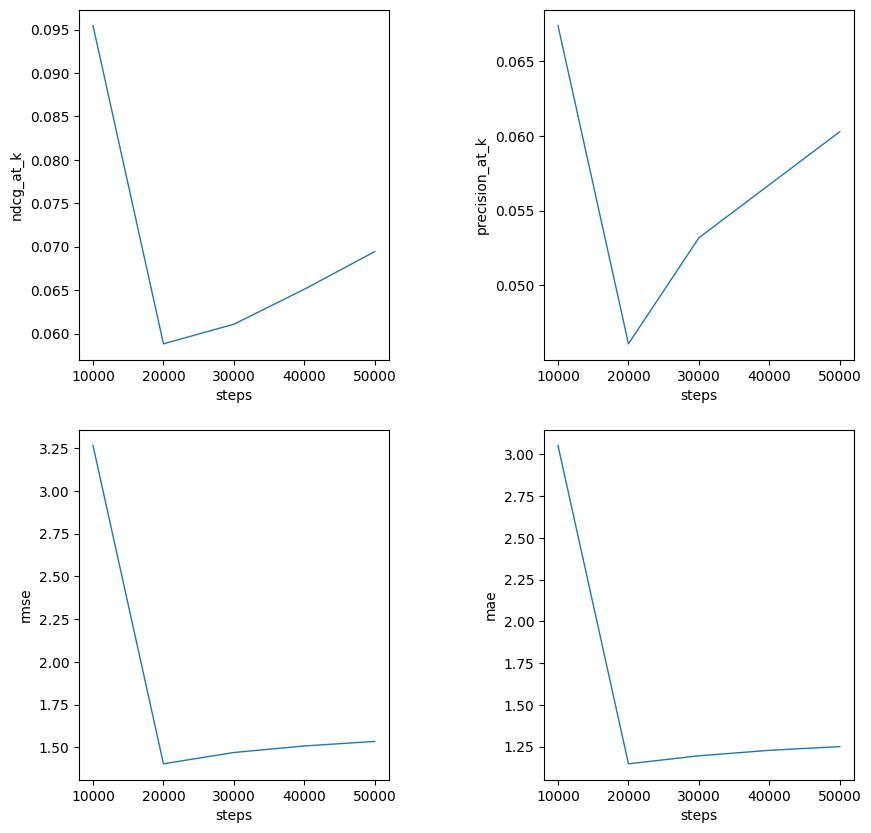

In [16]:
if EVALUATE_WHILE_TRAINING:
    logs = evaluation_logger.get_log()
    for i, (m, v) in enumerate(logs.items(), 1):
        #store_metadata("eval_{}".format(m), v)
        x = [save_checkpoints_steps*i for i in range(1, len(v)+1)]
        plot.line_graph(
            values=list(zip(v, x)),
            labels=m,
            x_name="steps",
            y_name=m,
            subplot=(math.ceil(len(logs)/2), 2, i),
        )

In [18]:

if len(RATING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=test)))
    prediction_df = test.drop(RATING_COL, axis=1)
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]
    
    rating_results = {}
    for m in RATING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **cols)
        #store_metadata(m, result)
        rating_results[m] = result
    print(rating_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\DEMONS~1\AppData\Local\Temp\tmpemnf2s3o\model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'rmse': 1.555692938115201, 'mae': 1.266195013527329}


In [20]:
if len(RANKING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=ranking_pool)))
    prediction_df = ranking_pool.copy()
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]

    ranking_results = {}
    for m in RANKING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **{**cols, 'k': TOP_K})
        #store_metadata(m, result)
        ranking_results[m] = result
    print(ranking_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\DEMONS~1\AppData\Local\Temp\tmpemnf2s3o\model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'ndcg_at_k': 0.06802321474869602, 'precision_at_k': 0.056737588652482254}


In [21]:
os.makedirs(EXPORT_DIR_BASE, exist_ok=True)

In [23]:

exported_path = tf_utils.export_model(
    model=model,
    train_input_fn=train_fn,
    eval_input_fn=tf_utils.pandas_input_fn(
        df=test, y_col=RATING_COL
    ),
    tf_feat_cols=wide_columns+deep_columns,
    base_dir=EXPORT_DIR_BASE
)
#store_metadata('saved_model_dir', str(exported_path))
print("Model exported to", str(exported_path))

Model exported to outputs\model\1711370218


In [24]:
# Close the event file so that the model folder can be cleaned up.
summary_writer = tf.compat.v1.summary.FileWriterCache.get(model.model_dir)
summary_writer.close()

# Cleanup temporary directory if used
if TMP_DIR is not None:
    TMP_DIR.cleanup()